In [18]:
# Import modules and packages
import streamlit as st
import tensorflow 
import numpy as np
np.random.seed(4)
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import datetime as dt
from datetime import datetime
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

%matplotlib inline

In [20]:
# Importing Training Set
dataset_train = pd.read_excel('HLAD_ORLIST.xlsx')


# Select features (columns) to be involved intro training and predictions
cols = list(dataset_train)[1:3]
dataset_train



,Fecha,Carga (MW),TEMP,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,TEMP.1
0,2019-01-01 00:00:00,113540.40,291.982209,NaN,NaN,NaN,NaN,18.832209
1,2019-01-01 01:00:00,109174.36,291.334626,NaN,NaN,NaN,NaN,18.184626
2,2019-01-01 02:00:00,105467.22,290.780670,NaN,NaN,NaN,NaN,17.630671
3,2019-01-01 03:00:00,101759.86,290.315949,NaN,NaN,NaN,NaN,17.165949
4,2019-01-01 04:00:00,94715.00,289.890900,NaN,NaN,NaN,NaN,16.740900
...,...,...,...,...,...,...,...,...
8755,2019-12-31 19:00:00,153382.61,299.177796,NaN,NaN,NaN,NaN,26.027796
8756,2019-12-31 20:00:00,146458.22,297.865296,NaN,NaN,NaN,NaN,24.715296
8757,2019-12-31 21:00:00,134353.18,296.626343,NaN,NaN,NaN,NaN,23.476343
8758,2019-12-31 22:00:00,123372.47,294.267060,NaN,NaN,NaN,NaN,21.117060


In [22]:
# Extract dates (will be used in visualization)
datelist_train = dataset_train['Fecha']



In [24]:
datelist_train = list(datelist_train.dt.to_pydatetime())


In [25]:
print('Training set shape == {}'.format(dataset_train.shape))
print('All timestamps == {}'.format(len(datelist_train)))
print('Featured selected: {}'.format(cols))


Training set shape == (8760, 2)
All timestamps == 8760
Featured selected: ['Carga (MW)', 'TEMP']


In [26]:
dataset_train = dataset_train[cols].astype(str)
for i in cols:
    for j in range(0, len(dataset_train)):
        dataset_train[i][j] = dataset_train[i][j].replace(',', '')

dataset_train = dataset_train.astype(float)
dataset_train


,Carga (MW),TEMP
Fecha,,
2019-01-01 00:00:00,113540.40,291.982209
2019-01-01 01:00:00,109174.36,291.334626
2019-01-01 02:00:00,105467.22,290.780670
2019-01-01 03:00:00,101759.86,290.315949
2019-01-01 04:00:00,94715.00,289.890900
...,...,...
2019-12-31 19:00:00,153382.61,299.177796
2019-12-31 20:00:00,146458.22,297.865296
2019-12-31 21:00:00,134353.18,296.626343


In [27]:
# Using multiple features (predictors)
training_set = dataset_train.values

print('Shape of training set == {}.'.format(training_set.shape))
training_set

Shape of training set == (8760, 2).


array([[113540.4      ,    291.9822086],
       [109174.36     ,    291.3346256],
       [105467.22     ,    290.7806705],
       ...,
       [134353.18     ,    296.6263432],
       [123372.47     ,    294.2670597],
       [115380.71     ,    292.9093021]])

In [28]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
training_set_scaled = sc.fit_transform(training_set)
training_set.shape


(8760, 2)

In [29]:
sc_predict = StandardScaler()
sc_predict.fit_transform(training_set[:,0:1])


array([[-0.60228585],
       [-0.7889482 ],
       [-0.94744045],
       ...,
       [ 0.28752792],
       [-0.181933  ],
       [-0.52360663]])

In [30]:
# Creating a data structure with 90 timestamps and 1 output
X_train = []
y_train = []

n_future = 192   # Number of days we want top predict into the future
n_past = 300    # Number of past days we want to use to predict the future

for i in range(n_past, len(training_set_scaled) - n_future +1):
    X_train.append(training_set_scaled[i - n_past:i, 0:dataset_train.shape[1] - 1])
    y_train.append(training_set_scaled[i + n_future - 1:i + n_future, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

print('X_train shape == {}.'.format(X_train.shape))
print('y_train shape == {}.'.format(y_train.shape))

X_train shape == (8269, 300, 1).
y_train shape == (8269, 1).


<h3>Step #3. Building the LSTM based Neural Network</h3>

In [31]:
# Import Libraries and packages from Keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam

In [32]:
# Initializing the Neural Network based on LSTM
model =tensorflow.keras.Sequential()

# Adding 1st LSTM layer
model.add(LSTM(units=64, return_sequences=True, input_shape=(n_past, dataset_train.shape[1]-1)))

# Adding 2nd LSTM layer
model.add(LSTM(units=10, return_sequences=False))

# Adding Dropout
model.add(Dropout(0.25))

# Output layer
model.add(Dense(units=1, activation='linear'))

# Compiling the Neural Network
model.compile(optimizer = Adam(learning_rate=0.01), loss='mean_squared_error')

In [34]:
%%time
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=10, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
mcp = ModelCheckpoint(filepath='weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

tb = TensorBoard('logs')

history = model.fit(X_train, y_train, shuffle=True, epochs=30, callbacks=[es, rlr, mcp, tb], validation_split=0.2, verbose=1, batch_size=256)

Epoch 1/30
26/26 [==============================] - ETA: 0s - loss: 0.4332
Epoch 00001: val_loss improved from inf to 0.37355, saving model to weights.h5
26/26 [==============================] - 33s 1s/step - loss: 0.4332 - val_loss: 0.3735
Epoch 2/30
26/26 [==============================] - ETA: 0s - loss: 0.2989
Epoch 00002: val_loss improved from 0.37355 to 0.28425, saving model to weights.h5
26/26 [==============================] - 29s 1s/step - loss: 0.2989 - val_loss: 0.2842
Epoch 3/30
26/26 [==============================] - ETA: 0s - loss: 0.2854
Epoch 00003: val_loss improved from 0.28425 to 0.27551, saving model to weights.h5
26/26 [==============================] - 35s 1s/step - loss: 0.2854 - val_loss: 0.2755
Epoch 4/30
26/26 [==============================] - ETA: 0s - loss: 0.2757
Epoch 00004: val_loss improved from 0.27551 to 0.27550, saving model to weights.h5
26/26 [==============================] - 30s 1s/step - loss: 0.2757 - val_loss: 0.2755
Epoch 5/30
26/26 [======

In [16]:
# Generate list of sequence of days for predictions
datelist_future = pd.date_range(datelist_train[-1], periods=n_future, freq='1H').tolist()

'''
Remeber, we have datelist_train from begining.
'''

# Convert Pandas Timestamp to Datetime object (for transformation) --> FUTURE
datelist_future_ = []
for this_timestamp in datelist_future:
    datelist_future_.append(this_timestamp.date())

In [17]:
# Perform predictions
predictions_future = model.predict(X_train[-n_future:])

predictions_train = model.predict(X_train[n_past:])

In [19]:
# Inverse the predictions to original measurements

# ---> Special function: convert <datetime.date> to <Timestamp>
def datetime_to_timestamp(x):
    '''
        x : a given datetime value (datetime.date)
    '''
    return datetime.strptime(x.strftime('%Y%m%d %H:%M:%S'), '%Y%m%d %H:%M:%S') #'%Y%m%d %H:%M:%S'


y_pred_future = sc_predict.inverse_transform(predictions_future)
y_pred_train = sc_predict.inverse_transform(predictions_train)

PREDICTIONS_FUTURE = pd.DataFrame(y_pred_future, columns=['Carga (MW)']).set_index(pd.Series(datelist_future))
PREDICTION_TRAIN = pd.DataFrame(y_pred_train, columns=['Carga (MW)']).set_index(pd.Series(datelist_train[2 * n_past + n_future -1:]))

# Convert <datetime.date> to <Timestamp> for PREDCITION_TRAIN
PREDICTION_TRAIN.index = PREDICTION_TRAIN.index.to_series().apply(datetime_to_timestamp)

PREDICTION_TRAIN.head(3)

,Carga (MW)
2019-02-02 23:00:00,119833.703125
2019-02-03 00:00:00,111475.429688
2019-02-03 01:00:00,105236.070312


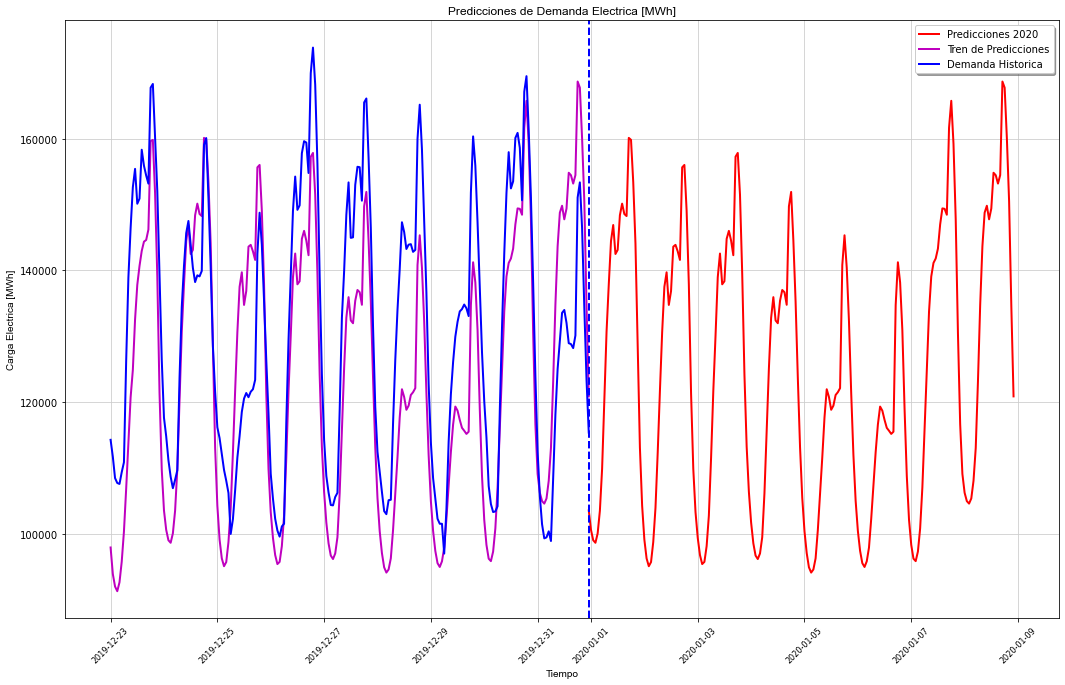

In [72]:
# Set plot size 
from pylab import rcParams
rcParams['figure.figsize'] = 17.8, 11

# Plot parameters
START_DATE_FOR_PLOTTING = '2019-12-23 00:00:00'
plt.plot(PREDICTIONS_FUTURE.index, PREDICTIONS_FUTURE['Carga (MW)'], color='r', label='Predicciones 2020', linewidth=2)
plt.plot(PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:].index, PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:]['Carga (MW)'], color='m', label='Tren de Predicciones', linewidth=2)
plt.plot(dataset_train.loc[START_DATE_FOR_PLOTTING:].index, dataset_train.loc[START_DATE_FOR_PLOTTING:]['Carga (MW)'], color='b', label='Demanda Historica', linewidth=2)


plt.axvline(x = min(PREDICTIONS_FUTURE.index), color='b', linewidth=2, linestyle='--')

plt.grid(which='major', color='#cccccc', alpha=1)
plt.legend(shadow=True)
plt.title('Predicciones de Demanda Electrica [MWh]', family='Arial', fontsize=12)
plt.xlabel('Tiempo', family='Arial', fontsize=10)
plt.ylabel('Carga Electrica [MWh]', family='Arial', fontsize=10)
plt.xticks(rotation=45, fontsize=8)
plt.show()




In [23]:
# Parse training set timestamp for better visualization
dataset_train = pd.DataFrame(dataset_train, columns=cols)
dataset_train.index = datelist_train
dataset_train.index = pd.to_datetime(dataset_train.index)